# Lab 3: Classification 

In this lab, you will gain experience with several classification algorithms, including Logistic Regression, Naive Bayes, and Support-Vector Machines. You will also work towards building a modular machine learning pipeline that you can use for your class project and hopefully many other projects in the future. Finally, you will gain experience with geospatial data analysis.

You will work with the crime data from Chicago's Open Data Portal to better understand the crimes that are reported in different neighborhoods in the city, whether those crimes result in arrest, and so forth. As in previous labs, you will acquite the data and familiarize yourself with its basic properties. You will then explore a few classification problems using different machine learning models.

## Learning Objectives

* Starting to build a reusable data science / machine learning analysis pipeline 
* Creating functions with fixed modules and steps that can be reused for your final project
* Writing several `scikit-learn` features by hand, like `GridSearchCV`
* Applying the following classification models (essentially plugging different functions into the same pipeline):
    * Logistic Regression
    * Naive Bayes
    * Support-Vector Machines

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import xticks
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator
import seaborn as sns
import squarify
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

# Import the linear models from scikit-learn
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.model_selection import KFold, cross_val_score

%matplotlib inline

## Part 1: Data Acquisition and Exploratory Analysis

In the first part of the lab, you will acquire data from the Chicago Open Data Portal concerning crime statistics and perform basic exploration and analysis.

### 1.1 Data Download

Download [reported crime data for 2019](https://data.cityofchicago.org/Public-Safety/Crimes-2019/w98m-zvie) from the Chicago Open Data Portal. Your dataset should have roughly 260,000 observations. As always, think about what each row represents and familiarize yourself with the variables. 

In [2]:
df = pd.read_csv("/Users/mayar/Documents/Mayarak/MSCAPP/MSCAPP/Spring Quarter 2020\Machine Learning for Public Policy/Assingments_MachineLearningforPublicPolicy/HW3_MachineLearningforPublicPolicy/Crimes_-_2019.csv")

In [3]:
df.shape

(259033, 22)

In [4]:
df.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12045569,JD226399,02/04/2019 12:01:00 AM,0000X W 95TH ST,0810,THEFT,OVER $500,CONSTRUCTION SITE,False,False,...,21.0,49,06,NaN,NaN,2019,05/08/2020 03:50:02 PM,NaN,NaN,NaN
1,12044395,JD224616,07/07/2019 12:00:00 AM,001XX N STATE ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,42.0,32,11,1176336.0,1901423.0,2019,05/08/2020 03:48:21 PM,41.884862,-87.62792,"(41.8848616, -87.627920479)"


In [5]:
df[['DATE','HOUR']] = df['Date'].str.split(" ",n=1,expand=True) 

In [6]:
def lookup(s):
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [7]:
df['DATE'] = lookup(df['DATE'])

### 1.2 Basic Exploratory Analysis

Before delving into our analysis, we want to explore the reported crime data. Your task here is to generate visualizations for each question, exploring the number of crimes of each type, how these change over time, and how they vary across neighborhoods. Note that this is intentionally open ended – produce visualizations that you think would be meaningful. 

Each of your visualizations should include a title, labeled axes, and a brief (2-3 sentence) description.

#### 1.2.1 How many crimes of each type are in these data? 

In [8]:
df['COUNT'] =1

In [9]:
df_crimestype = df[['Primary Type', "COUNT"]]
df_crimestype = df_crimestype.groupby('Primary Type').count().reset_index()
df_crimestype = df_crimestype.sort_values(['COUNT'], ascending=False)

In [10]:
df_crimestype.head(2)

,Primary Type,COUNT
30,THEFT,62366
2,BATTERY,49485


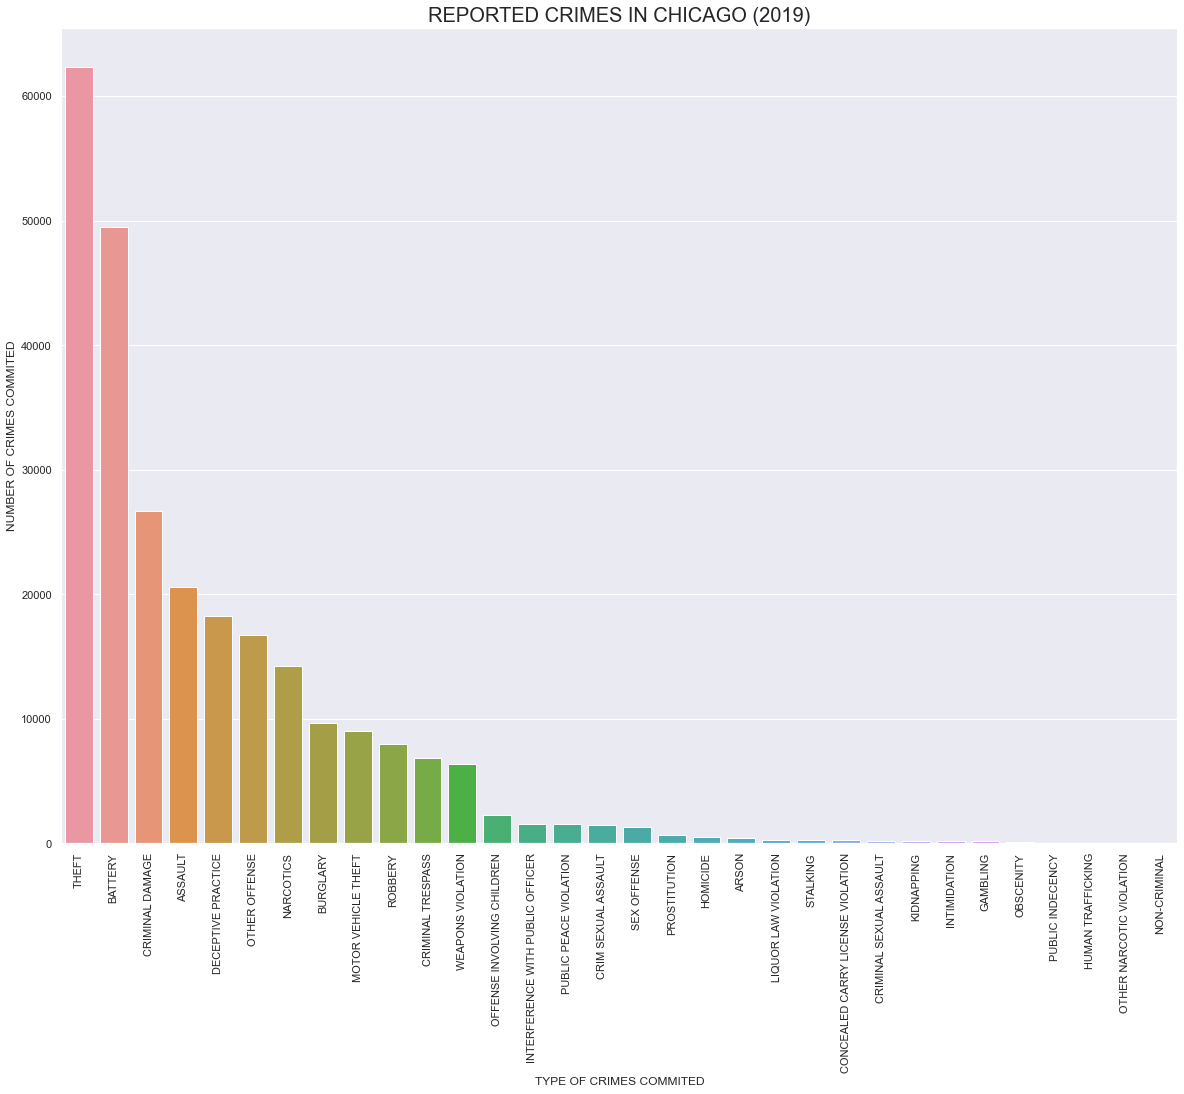

In [11]:
sns.set(rc={'figure.figsize':(20, 15)})

ax = sns.barplot(x="Primary Type", y="COUNT", data=df_crimestype)
ax.set(xlabel="TYPE OF CRIMES COMMITED", ylabel = "NUMBER OF CRIMES COMMITED")
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
plt.title('REPORTED CRIMES IN CHICAGO (2019)', fontsize = 20)
plt.show()

_This statistic shows the reported crimes in Chicago in 2019, here "Theft" was the one with more ocurrences and maybe the one that people feel as the closer threat to their safety._

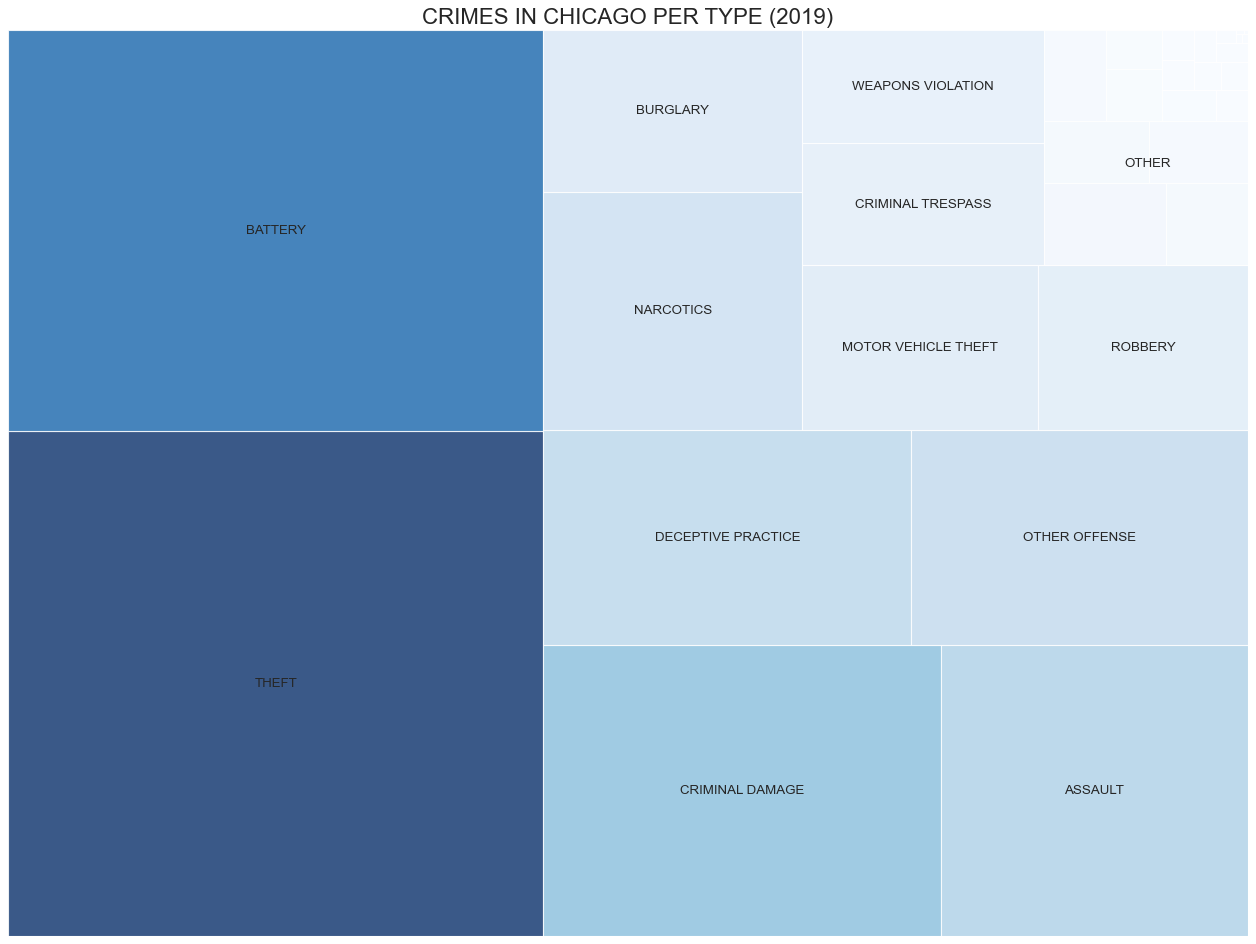

In [12]:
plt.figure(figsize=(20,15), dpi = 80)

df_crimestype.loc[df_crimestype['COUNT'] < 5e3, 'Primary Type'] = ''
norm = matplotlib.colors.Normalize(vmin=min(df_crimestype.COUNT), vmax=max(df_crimestype.COUNT))
colors = [matplotlib.cm.Blues(norm(value)) for value in df_crimestype.COUNT]
squarify.plot(sizes=df_crimestype['COUNT'], label=df_crimestype['Primary Type'], color = colors, alpha=.8 )
plt.text(90,85,'OTHER')
plt.title('CRIMES IN CHICAGO PER TYPE (2019)', fontsize=20)
plt.axis('off')
plt.show()

_This graph was created with the intention to show more clearly that there are other reported crimes in Chicago city and their proportion compared with the whole crimes universe._

#### 1.2.2 Is there any notable seasonality in the number of reported crimes? 

You can perform this analysis at the month or season level.

In [13]:
df_seasonality = df[['DATE', 'COUNT']]
df_seasonality = df_seasonality.groupby('DATE').count().reset_index()

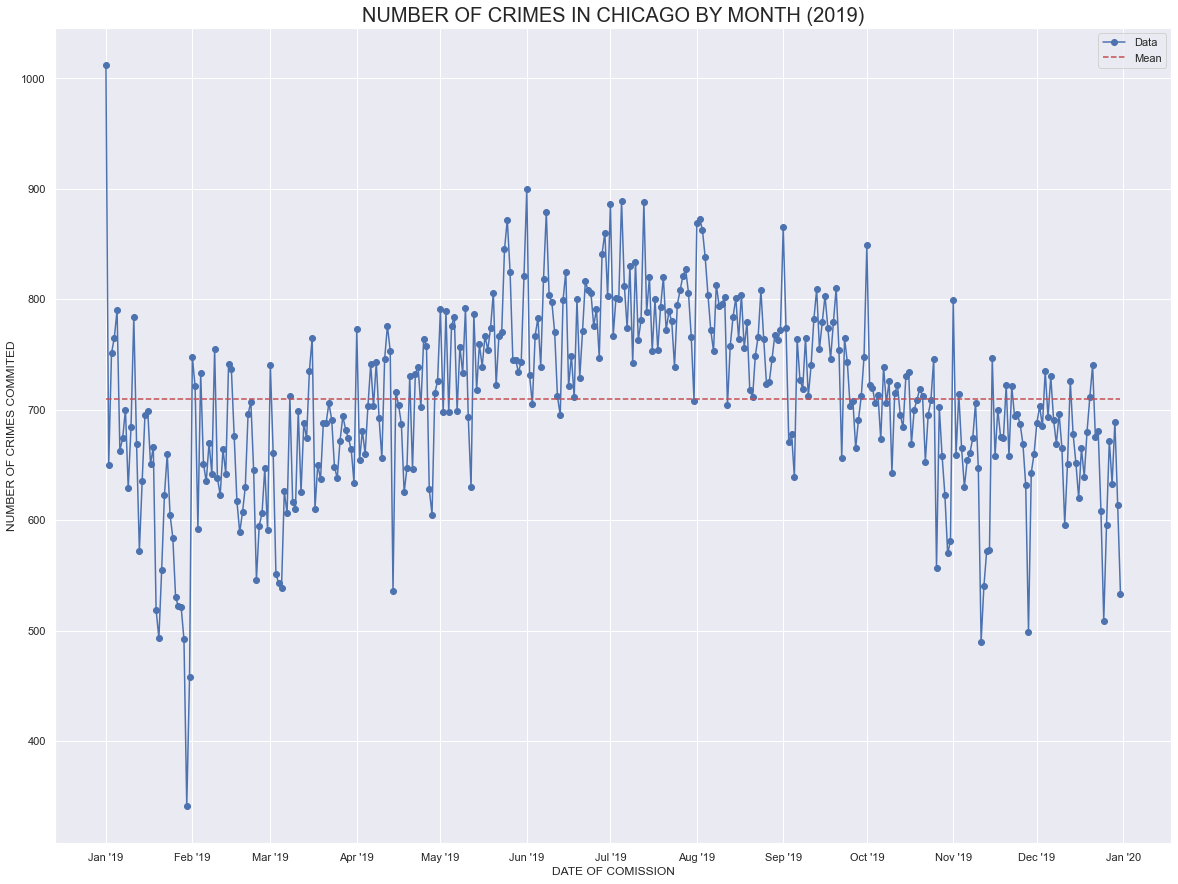

In [14]:
sns.set(rc={'figure.figsize':(20, 15)})

fig, ax = plt.subplots()
x = df_seasonality['DATE']
y = df_seasonality['COUNT']
y_mean = [np.mean(y)]*len(x)
data_line = ax.plot(x, y, color="b", label = 'Data', marker = 'o')
mean_line = ax.plot(x, y_mean, color ='r', label = 'Mean', linestyle = '--')
legend = ax.legend(loc='upper right')
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.set(xlabel="DATE OF COMISSION", ylabel = "NUMBER OF CRIMES COMMITED")
plt.title('NUMBER OF CRIMES IN CHICAGO BY MONTH (2019)', fontsize = 20)
plt.show()

_This statistic show the number of aggregated crimes in Chicago in 2019, which allows to identify a relation between an increase or decrease in the number of reported crimes and the period of the year in which they occured. It is possible to see that from mid-May to September, where the temperature tends to be higher, the number of crimes is above the average number of crimes. While, on the other hand, during colder months reported crimes are below the average._

#### 1.2.3 How did reported crimes vary across neighborhoods? 

You may find the [neighborhood boundaries data](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9) from the Chicago Data Portal and the `geopandas` [documentation on spatial joins](https://geopandas.org/mergingdata.html) useful here. A few more helpful resources can be found [here](https://gis.stackexchange.com/questions/174159/convert-a-pandas-dataframe-to-a-geodataframe) and [here](https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d).

Your data preparation process will likely include the following steps:
1. Load the neighborhood boundaries `geojson` file using `geopandas`.
2. Convert your crime dataframe to a `geopandas` dataframe.
3. Merge the crime `geopandas` dataframe and the neighborhoods `geopandas` dataframes.

In [15]:
geo_df = gpd.read_file('/Users/mayar/Documents/Mayarak/MSCAPP/MSCAPP/Spring Quarter 2020\Machine Learning for Public Policy/Assingments_MachineLearningforPublicPolicy/HW3_MachineLearningforPublicPolicy/Boundaries - Neighborhoods.geojson')
geo_df.head(2)

,pri_neigh,sec_neigh,shape_area,shape_len,geometry
0,Grand Boulevard,BRONZEVILLE,48492503.1554,28196.837157,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
1,Printers Row,PRINTERS ROW,2162137.97139,6864.247156,"MULTIPOLYGON (((-87.62761 41.87437, -87.62760 ..."


In [16]:
geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
df = df.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(df, crs=crs, geometry=geometry)
gdf.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Location,DATE,HOUR,COUNT,geometry
0,12045569,JD226399,02/04/2019 12:01:00 AM,0000X W 95TH ST,0810,THEFT,OVER $500,CONSTRUCTION SITE,False,False,...,06,NaN,NaN,2019,05/08/2020 03:50:02 PM,NaN,2019-02-04,12:01:00 AM,1,POINT (nan nan)
1,12044395,JD224616,07/07/2019 12:00:00 AM,001XX N STATE ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,11,1176336.0,1901423.0,2019,05/08/2020 03:48:21 PM,"(41.8848616, -87.627920479)",2019-07-07,12:00:00 AM,1,POINT (-87.628 41.885)


In [17]:
crime_gdf = gpd.sjoin(gdf, geo_df, how="inner", op = 'intersects')
crime_gdf.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Location,DATE,HOUR,COUNT,geometry,index_right,pri_neigh,sec_neigh,shape_area,shape_len
1,12044395,JD224616,07/07/2019 12:00:00 AM,001XX N STATE ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,"(41.8848616, -87.627920479)",2019-07-07,12:00:00 AM,1,POINT (-87.62792 41.88486),26,Loop,LOOP,31485185.0318,52640.907563
11,11921873,JC547150,12/14/2019 07:53:00 PM,0000X E LAKE ST,0320,ROBBERY,STRONG ARM - NO WEAPON,STREET,False,False,...,"(41.885730611, -87.625542215)",2019-12-14,07:53:00 PM,1,POINT (-87.62554 41.88573),26,Loop,LOOP,31485185.0318,52640.907563


### 1.3 Joining with Census Data

The crime dataset includes lat/long fields, which can be joined with Census data. Your task now is to augment that data with [American Community Survey data](https://www.census.gov/programs-surveys/acs/data.html). For each crime report, use one of the census APIs to get additional data about the demographics of the block where the crime report came from. At a minimum, this should include the percentage of each block that is African American/Black (`Percent Black`) and White (`Percent White`), along with the median income in each block (`Median Income`). 

We recommend using [ACS 5-Year Data](https://www.census.gov/data/developers/data-sets/acs-5year.html), which is estimated for all geographies down to the block-group level. You may find the following resources helpful in constructing your API call: [ACS API Variable Formats](https://www.census.gov/data/developers/data-sets/acs-1year/notes-on-acs-api-variable-formats.html) and [Census Query Examples](https://www.census.gov/data/developers/guidance/api-user-guide/query-examples.html). The [Census Block TIGER boundaries](https://data.cityofchicago.org/dataset/CensusBlockTIGER2010/bt9m-d2mf/data) from the Chicago Data Portal may also be helpful in performing a spatial join between the ACS data and the crime data. 

We've included an example using the `CensusData` API for a single field: B02001_001E (Total Population). In this example, we download the non-spatial block-level ACS data and merge it with the spatial block-level boundaries. We also create a quick map to verify that our output resembles Chicago. Feel free to leverage this code to pull your additional variables. 

,B02001_001E,GEO_ID,geometry
26417,1590,1500000US170311504012,"MULTIPOLYGON (((-87.76736 41.96413, -87.76767 ..."
43693,2177,1500000US170317004011,"MULTIPOLYGON (((-87.70705 41.74196, -87.70705 ..."
27900,1421,1500000US170311511002,"MULTIPOLYGON (((-87.76063 41.94139, -87.76064 ..."


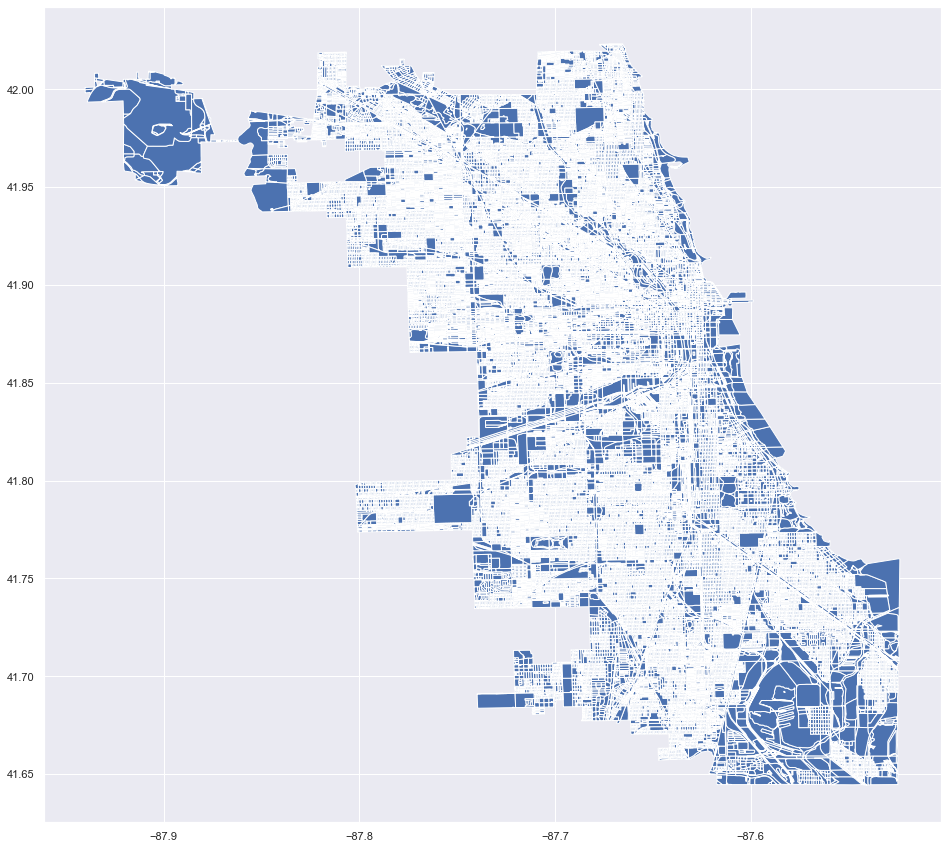

In [18]:
# --- Example of downloading ACS data from the CensusData API --- # 

import censusdata
import geopandas as gpd

# Note: IL FIPS = 17, Cook County FIPS = 031, Table = B02001_001E (Total Population)
acs_example = censusdata.download("acs5", 2015, censusdata.censusgeo(
    [("state", "17"), ("county", "031"), ("block group", "*")]), ["B02001_001E", "GEO_ID"])

# Download Census block boundaries for Chicago 
census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")

# Extract 12-digit FIPS code from both datasets 
census_gdf["geo_12"] = census_gdf["geoid10"].map(lambda x: str(x)[:12])
acs_example["geo_12"] = acs_example["GEO_ID"].map(lambda x: str(x)[-12:])

# Merge ACS data with Census block boundaries 
# Assumes the crime df was converted to a geopandas df (crime_gdf)  
merged_gdf = (gpd.GeoDataFrame(acs_example.merge(census_gdf, on="geo_12", how="inner"), 
                               crs=crime_gdf.crs))

# Limit columns 
limited_gdf = merged_gdf[["B02001_001E", "GEO_ID", "geometry"]].drop_duplicates()

# Plot geopandas dataframe with total population by Census block
limited_gdf.plot()

# Print a sample of rows 
limited_gdf.sample(3)

#### 1.3.1 Load ACS data, TIGER boundaries, and merge to crime data
Using the code provided above as a starting point, take the following steps in your data preparation:

1. Load the ACS data with at least variables for `Total Population`, `White`, `Black`, and `Median Income`.
2. Load the TIGER neighborhood boundaries `geopandas` dataframe.
3. Merge the ACS dataframe and the TIGER `geopandas` dataframe. The result will be a `geopandas` dataframe.
4. Merge the ACS `geopandas` dataframe that you created in step 3 with your crime `geopandas` dataframe from section 1.2.3 above.
5. Compute the percentage of each Census block's population that is White and African American/Black.

Based on this augmented data, explore the characteristics of blocks with crime reports. For instance, you might look into demographic trends as they relate to homicides or total reported crimes. Provide descriptive statistics and produce at least one visualization. Again, include a title, labeled axes, and a brief description.

,B02001_001E,B02001_002E,B02001_003E,B19013_001E,GEO_ID,geometry
406,1107,720,185,41938.0,1500000US170310206013,"MULTIPOLYGON (((-87.69908 41.99940, -87.69913 ..."
24703,1616,980,0,76164.0,1500000US170311204003,"MULTIPOLYGON (((-87.75519 41.97251, -87.75520 ..."
15603,1286,972,77,95667.0,1500000US170310630002,"MULTIPOLYGON (((-87.65146 41.93358, -87.65098 ..."


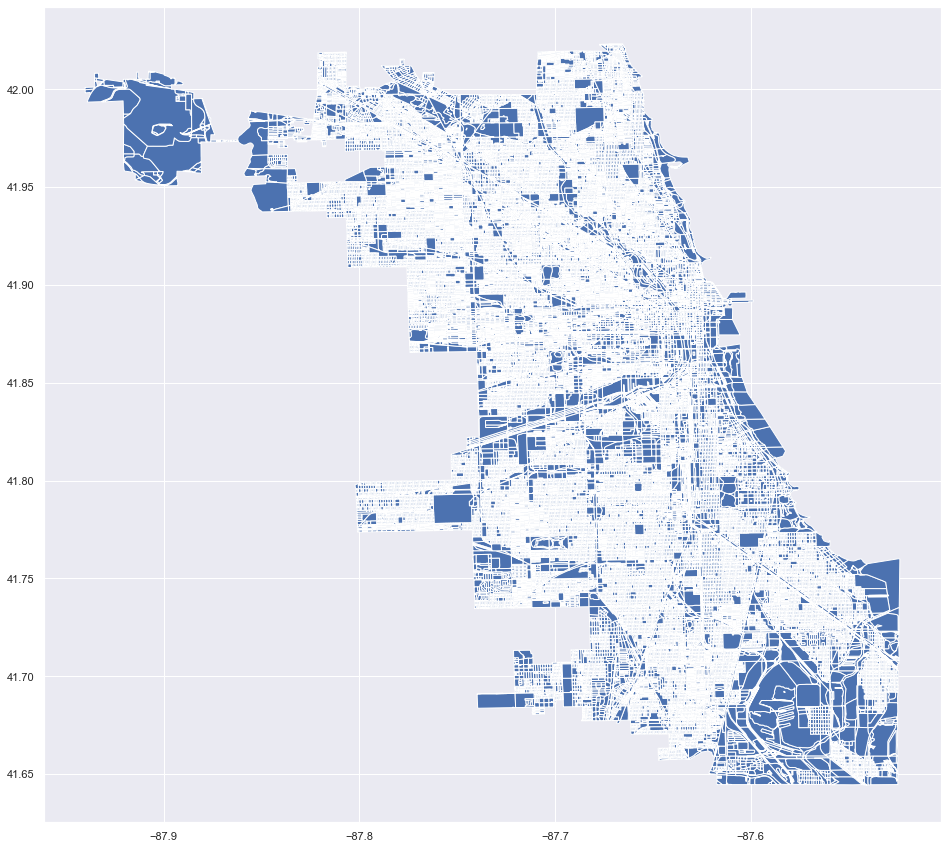

In [19]:
import censusdata
import geopandas as gpd

# Note: IL FIPS = 17, Cook County FIPS = 031, Table = B02001_001E (Total Population)
acs_dl = censusdata.download("acs5", 2015, censusdata.censusgeo(
    [("state", "17"), ("county", "031"), ("block group", "*")]), ["B02001_001E", "B02001_002E", "B02001_003E", 
                                                                  'B19013_001E', "GEO_ID"])

# Download Census block boundaries for Chicago 
census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")

# Extract 12-digit FIPS code from both datasets 
census_gdf["geo_12"] = census_gdf["geoid10"].map(lambda x: str(x)[:12])
acs_dl["geo_12"] = acs_example["GEO_ID"].map(lambda x: str(x)[-12:])

# Merge ACS data with Census block boundaries 
# Assumes the crime df was converted to a geopandas df (crime_gdf)  
acst_merged = (gpd.GeoDataFrame(acs_dl.merge(census_gdf, on="geo_12", how="inner"), 
                               crs=crime_gdf.crs))
# Limit columns 
limited_gdf = acst_merged[["B02001_001E", "B02001_002E", "B02001_003E",'B19013_001E',"GEO_ID",
                          "geometry"]].drop_duplicates()

# Plot geopandas dataframe with total population by Census block
limited_gdf.plot()

# Print a sample of rows 
limited_gdf.sample(3)


In [20]:
crime_gdf.rename(columns={"index_right": "previous_index_right"}, inplace = True)

In [21]:
merged_gdf = gpd.sjoin(crime_gdf, limited_gdf, how='inner', op = 'within')

In [22]:
merged_gdf.rename(columns={"B02001_001E": "TPOP", "B02001_002E": "WPOP", "B02001_003E": "BPOP", "B19013_001E":"MINC"}, 
                  inplace=True)
merged_gdf['WPOPPER'] = merged_gdf['WPOP']/merged_gdf['TPOP']
merged_gdf['BPOPPER'] = merged_gdf['BPOP']/merged_gdf['TPOP']
merged_gdf.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,shape_area,shape_len,index_right,TPOP,WPOP,BPOP,MINC,GEO_ID,WPOPPER,BPOPPER
1,12044395,JD224616,07/07/2019 12:00:00 AM,001XX N STATE ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,31485185.0318,52640.907563,6361,3643,2098,478,73221.0,1500000US170318391001,0.575899,0.131211
1906,11984427,JC583526,12/07/2019 06:59:00 PM,001XX N STATE ST,1330,CRIMINAL TRESPASS,TO LAND,DRUG STORE,True,False,...,31485185.0318,52640.907563,6361,3643,2098,478,73221.0,1500000US170318391001,0.575899,0.131211


### 1.4 Basic Bayesian Probability

Assume you are running the 911 call center for Chicago. You get a call from someone at 5801 S Ellis Ave.  In this section, we ask several basic questions. Produce your answers by writing code against the dataframes above.

You are also welcome to express your answer mathematically. You can use LaTeX syntax in notebooks to write equations.

**1.4.1. Which crime type is the most likely given the call came from 5801 S Ellis Ave? (What are the probabilities for each type of crime?)**

In [23]:
hydepark_crime = merged_gdf[merged_gdf['pri_neigh'] == 'Hyde Park']
hpcrime_probs = hydepark_crime.groupby('Primary Type').size() / hydepark_crime['Primary Type'].count()
hpcrime_probs

Primary Type
ASSAULT                             0.074424
BATTERY                             0.148258
BURGLARY                            0.032487
CRIM SEXUAL ASSAULT                 0.004725
CRIMINAL DAMAGE                     0.076787
CRIMINAL SEXUAL ASSAULT             0.000591
CRIMINAL TRESPASS                   0.021264
DECEPTIVE PRACTICE                  0.105729
INTERFERENCE WITH PUBLIC OFFICER    0.001772
INTIMIDATION                        0.000591
KIDNAPPING                          0.000591
MOTOR VEHICLE THEFT                 0.037212
NARCOTICS                           0.009451
OBSCENITY                           0.000591
OFFENSE INVOLVING CHILDREN          0.009451
OTHER OFFENSE                       0.066745
PUBLIC PEACE VIOLATION              0.001181
ROBBERY                             0.043709
SEX OFFENSE                         0.007679
STALKING                            0.002953
THEFT                               0.345540
WEAPONS VIOLATION                   0.0082

_Given that the call came from 5801 S Ellis Ave, which belongs to Hyde Park neighborhood, "theft" is the most likely crime that will be reported because it is the crime that is reported 34% of times in that specific neighborhood._

**1.4.2. Let’s now assume that a call comes in about Theft. Which is more likely – that the call came from Logan Square or Hyde Park? How much more or less likely is it to be from Logan Square vs. Hyde Park?**

You can consult [this link](https://en.wikipedia.org/wiki/Community_areas_in_Chicago) to see a list of community areas and their numbers, which corresponds to the `Community Area` field in the crime dataframe.

In [24]:
logansquare_crime = merged_gdf[merged_gdf['Community Area'] == 22]
hydepark_crime = merged_gdf[merged_gdf['Community Area'] == 41]

In [25]:
total_theft = merged_gdf.groupby('Primary Type').size()['THEFT']
hp_theft =  hydepark_crime.groupby('Primary Type').size()['THEFT']
ls_theft = logansquare_crime.groupby('Primary Type').size()['THEFT']

prob_theft = [hp_theft / total_theft,
        ls_theft / total_theft]

print("P(y = Hyde Park) = {:10.4f}\nP(y = Logan Square) = {:10.4f}".format(prob_theft[0],prob_theft[1]))

P(y = Hyde Park) =     0.0095
P(y = Logan Square) =     0.0293


In [26]:
likelihood = prob_theft[1]/prob_theft[0]
likelihood

3.071794871794872

_It is 208% more likely that the call will come from Logan Square._

**1.4.3. Now assume that you don’t have access to all the raw data and you know the following facts:**

* There are a total of 2000 calls, 800 from Garfield Park and 500 from Uptown. 
* Of the 800 calls from Garfield Park, 200 of them are about Battery. 
* Of the 500 calls from Uptown, 160 are about Battery. 

If a call comes about Battery, how much more/less likely is it that the call came from Garfield Park versus Uptown?

In [27]:
total_calls = 1300
battery_garfieldpark = 200
battery_uptown = 160

prob_battery = [battery_garfieldpark / total_calls, 
               battery_uptown / total_calls]

print("P(y = Garfield Park) = {:10.4f}\nP(y = Uptown) = {:10.4f}".format(prob_battery[0],prob_battery[1]))

P(y = Garfield Park) =     0.1538
P(y = Uptown) =     0.1231


In [28]:
likelihood = prob_battery[0]/prob_battery[1]
likelihood

1.25

_It is 25% more likely that the call will come from Gardfield Park._

---

## Part 2: Machine Learning Pipeline

When working on supervised machine learning projects, you will find yourself repeatedly performing tasks with slight variations. This naturally lends itself to a pipeline – or a set of functions that can help automate your workflow. The goal of this section is to start to build a simple, modular, and extensible pipeline, and then to apply this pipeline to the classification problem described above (i.e. predicting whether an arrest occured).

**Do NOT use `sklearn.pipeline.Pipeline()` here**. An important objective of this assignment is to understand how this process works and the ways different steps can be customized when designed from scratch.

You may find it useful to read through Part 2 in its entirety before beginning. You will use the code you write for your pipeline in Part 2.1 to answer the questions in Part 2.2.

### 2.1 Building the Pipeline 

To reiterate, the objective here is to build a simple and modular pipeline that can be extended throughout the quarter. Your framework should include the components described below, but is likely to evolve as you begin applying it to different machine learning tasks. Your functions should be well-documented and appropriately named. Focus on the structure, modularity, and extensibility. 

Your functions should be written in a separate `pipeline.py` file that you import into this (and future) notebooks. At a minimum, include the following components – 

1. **Read Data**  
Write 1 function in `pipeline.py` to load the data. Your function for reading in data can be as simple as calling `pd.read_csv`. If this step is more complicated (e.g. in your projects), you will want to write more detailed functions.
2. **Explore Data**  
Write at least 2 functions in `pipeline.py` to automate common exploratory tasks. This can include generating distributions of variables, correlations between them, identifying outliers, summarizing by groups, identifying the time range of the data, etc. Feel free to leverage your work from previous labs and Step 1 above.
3. **Create Training and Testing Sets**  
Write 1 function in `pipeline.py` to create training and testing splits. For this assignment, this step can be as simple as calling `sklearn.model_selection.train_test_split`. Later on, you should use a separate training set, validation set (to tune hyperparameters), and testing set to perform cross-validation.  
4. **Pre-Process Data**  
Write 2 functions in `pipeline.py` to automate pre-processing steps. One function should impute missing values of continuous variables using the median value and the other should normalize continuous variables. 
5. **Generate Features**   
Write 2 functions in `pipeline.py` to faciliate feature generation. One function should perform one-hot encoding of categorical variables (e.g. with `pd.get_dummies`) and one function should discretize continuous variables (e.g. with `pd.cut`). Discretizing continuous variables can be useful in cases where the variable has a significant cutoff value (for example, age could be discretized to distinguish between children under 18 and adults 18 and older).
6. **Build Classifiers**   
Write 1 function in `pipeline.py` that applies at least one machine learning model to a dataset. The function should also print the amount of time required to train each model. Several `scikit-learn` methods will be useful here, including `set_params` and `model_selection.ParameterGrid`. 
7. **Evaluate Classifiers**  
Write 1 function in `pipeline.py` that calculates the accuracy of your models based on your testing set. Again, you do NOT need a third validation set at this point in the quarter.

Import your pipeline into this notebook in the cell below. 

In [29]:
%load_ext autoreload
%autoreload 2
import pipeline as pipeline 

### 2.2 Applying the Pipeline 

Your task is to build a classifier that predicts the binary outcome of whether an arrest occured in each report (`Arrest`). Your classifier should take the following features as inputs: 
- `Primary Type` 
- `Ward` 
- `FBI Code`
- `Percent White` 
- `Percent Black`
- `Median Income`

Note that the three features from the crime data (`Primary Type`, `Ward`, and `FBI Code`) are categorical, while the three features from the ACS data (`Percent White`, `Percent Black`, and `Median Income`) are continuous. 

Train and evaluate the following types of classifiers: 
- Logistic Regression (`sklearn.linear_model.LogisticRegression`) 
- Support Vector Machines (`sklearn.svm.LinearSVC`)
- Naive Bayes (`sklearn.naive_bayes.GaussianNB`)

Use the helper functions that you wrote in your `pipeline.py` file to work through this classification task. The majority of the work in each cell should be performed by your `pipeline.py` functions, but you can add some extra code in this notebook if need be.

#### 2.2.1 Read Data (Call from Part 1)
We will be using the dataset compiled in Step 1. Feel free to drop any extra columns that you may have acquired in merging datasets above, and print out the first few rows of this dataset. 

In [30]:
new_gdf = merged_gdf[['Primary Type','Arrest', 'Ward','FBI Code','MINC','WPOPPER','BPOPPER']]
new_gdf.rename(columns={"MINC": "Median Income", "WPOPPER":"Percent White", "BPOPPER":"Percent Black"}, inplace = True)

In [31]:
new_gdf.head(5)

,Primary Type,Arrest,Ward,FBI Code,Median Income,Percent White,Percent Black
1,DECEPTIVE PRACTICE,False,42.0,11,73221.0,0.575899,0.131211
1906,CRIMINAL TRESPASS,True,42.0,26,73221.0,0.575899,0.131211
3223,ROBBERY,True,42.0,03,73221.0,0.575899,0.131211
3243,THEFT,False,42.0,06,73221.0,0.575899,0.131211
4853,THEFT,False,42.0,06,73221.0,0.575899,0.131211


#### 2.2.2 Explore Data
Apply one of the exploration functions in your pipeline on this dataset. 

In [32]:
new_gdf.describe().round()

,Ward,Median Income,Percent White,Percent Black
count,256959.0,247227.0,255473.0,255473.0
mean,23.0,-4475190.0,0.0,1.0
std,14.0,54724411.0,0.0,0.0
min,1.0,-666666666.0,0.0,0.0
25%,10.0,25560.0,0.0,0.0
50%,24.0,36667.0,0.0,1.0
75%,34.0,60682.0,1.0,1.0
max,50.0,189688.0,1.0,1.0


_Minimum value of Median Income is -666,666,666,  which seems to be an outlier. Based on the information on this website https://www.arcgis.com/home/item.html?id=45ede6d6ff7e4cbbbffa60d34227e462 negative values (e.g., -555555...) have been set to null, possibly because there were no sample observations or too few sample observations were available to compute a standard error. Looking more deeply into the data, there are no more negative observations besides those set to -666666666, what rules out the possibility of having negative values because of debt. Since the total number of observations setted to null represents less than 1% og the total observations (0.645%), they were deleted from the database._

In [33]:
new_gdf = new_gdf[new_gdf['Median Income'] > 0]

#### 2.2.3 Create Training and Testing Sets
Recall that all pre-processing steps must be done separately on your training and testing data. As a result, you should split your data into training and testing sets at the onset. Print out the number of observations in your training and testing sets. 

In [34]:
X_train, X_test, y_train, y_test = pipeline.split_dataset(new_gdf, (['Primary Type', 'Ward','FBI Code','Median Income',
                                                                     'Percent White','Percent Black']),['Arrest'])
print('Number of observations in \033[1mX_train\033[0m:{:,}'.format(X_train.shape[0]), 
      '\nNumber of observations in \033[1mX_test\033[0m:{:,}'.format(X_test.shape[0]),'\n'
     '\nNumber of observations in \033[1my_train\033[0m:{:,}'.format(y_train.shape[0]),
     '\nNumber of observations in \033[1my_test\033[0m:{:,}'.format(y_test.shape[0]),)

Number of observations in X_train:196,440 
Number of observations in X_test:49,110 

Number of observations in y_train:196,440 
Number of observations in y_test:49,110


#### 2.2.4 Pre-Process Data & Generate Features

We will do these steps separately for the label, the numeric features, and the categorical features.  

First, convert the label `Arrest` into a numerical (rather than boolean) feature in both your training and testing data. Print the percentage of recorded crimes in your training data that resulted in an arrest. 

In [35]:
y_train, y_test = pipeline.convert_numerical(y_train, y_test, "Arrest")

In [36]:
crimes_arrest = y_train.groupby('Arrest').size() / y_train['Arrest'].count()
print('Percentage of record crimes that resulted in an arrest in \033[1mtraining data\033[0m:{}%'.
      format((crimes_arrest[1]*100).round(2)))

Percentage of record crimes that resulted in an arrest in training data:21.2%


Next, pre-process the continuous numeric features (`Percent White`, `Percent Black`, `Median Income`). This should include the following steps: 
1. Impute missing values. Here, feel free to simply use the mean or the median of the column. 
2. Normalize each feature to have a mean of zero and standard deviation of one. Recall that this should be done based on the training data. 

Note that administrative data often uses encodings to indicate missing data. Always be sure to perform sanity checks (e.g. ensure that your percentages fall between 0 and 1, that income follows a reasonable distribution, etc.) 

In [37]:
X_train_impute = pipeline.impute_missing(X_train, X_train, ['Percent White', 'Percent Black', 'Median Income'])

In [38]:
X_test_impute = pipeline.impute_missing(X_test, X_train, ['Percent White', 'Percent Black', 'Median Income'])

In [39]:
X_train_normalized = pipeline.normalize_continuous(X_train_impute , X_train_impute , ['Percent White', 'Percent Black', 'Median Income'])

In [40]:
X_test_normalized = pipeline.normalize_continuous(X_test_impute, X_train_impute , ['Percent White', 'Percent Black', 'Median Income'])

In [41]:
X_train_normalized.describe().round()

,Ward,Median Income,Percent White,Percent Black
count,196429.0,196440.0,196440.0,196440.0
mean,23.0,-0.0,0.0,0.0
std,14.0,1.0,1.0,1.0
min,1.0,-1.0,-1.0,-1.0
25%,10.0,-1.0,-1.0,-1.0
50%,24.0,-0.0,-0.0,0.0
75%,34.0,0.0,1.0,1.0
max,50.0,5.0,2.0,1.0


In [42]:
X_test_normalized.describe().round()

,Ward,Median Income,Percent White,Percent Black
count,49107.0,49110.0,49110.0,49110.0
mean,23.0,-0.0,-0.0,0.0
std,14.0,1.0,1.0,1.0
min,1.0,-1.0,-1.0,-1.0
25%,10.0,-1.0,-1.0,-1.0
50%,24.0,-0.0,-0.0,0.0
75%,34.0,0.0,1.0,1.0
max,50.0,5.0,2.0,1.0


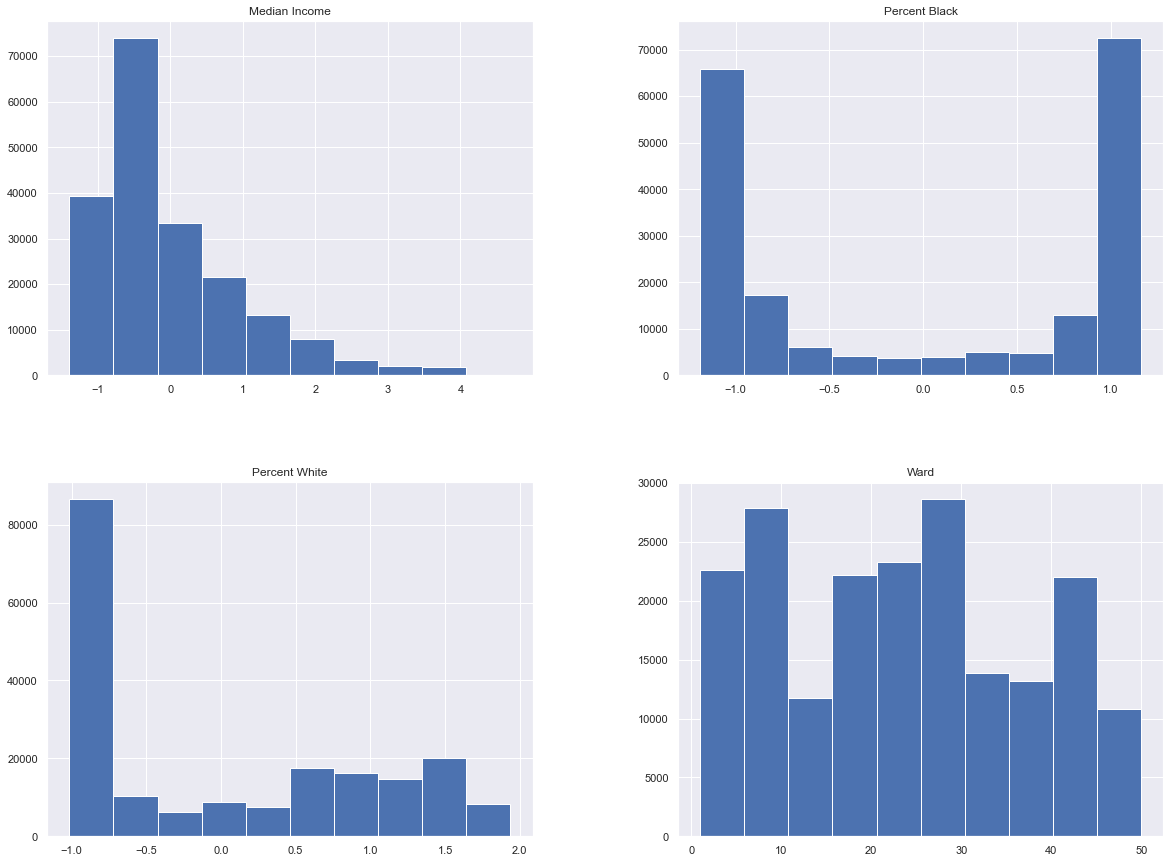

In [43]:
X_train_normalized.hist()
plt.show()

Finally, encode features from the categorical variables (`Primary Type`, `Ward`, and `FBI Code`). The standard way to encode categorical features in machine learning is through one-hot encoding. The function `pd.get_dummies` will be useful. 

An inherent issue arises with this approach when a value appears in either your training or testing data, but not in both. If a value appears in your training set but not your testing set, create a column with all 0's in your testing set. If a value appears in your testing set but not your training set, drop it from your testing data. 

In [44]:
X_train_processed, X_test_processed = pipeline.generate_hotenconding(X_test_normalized, X_train_normalized, ['Primary Type', 'Ward', 'FBI Code'])

We now have a modeling dataset that we can use to train and evaluate classifiers. Print out the first few rows of your training dataset. At this point, your dataset should only include the features created above and the label `Arrest`. 

In [45]:
X_train_processed.head(2)

,Median Income,Percent White,Percent Black,Primary Type__ARSON,Primary Type__ASSAULT,Primary Type__BATTERY,Primary Type__BURGLARY,Primary Type__CONCEALED CARRY LICENSE VIOLATION,Primary Type__CRIM SEXUAL ASSAULT,Primary Type__CRIMINAL DAMAGE,...,FBI Code__14,FBI Code__15,FBI Code__16,FBI Code__17,FBI Code__18,FBI Code__19,FBI Code__20,FBI Code__22,FBI Code__24,FBI Code__26
46866,-0.413055,-0.070254,0.085802,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171335,0.961995,1.683909,-1.135992,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We've provided a `sanity_check` function below to help check these steps. Pass your training and testing sets through this function to confirm that your features match across your training and testing data and that you have no missing values. 

In [46]:
def sanity_check(train_df, test_df): 
    
    # Sort features alphabetically
    train_df = train_df.reindex(sorted(train_df.columns), axis=1)
    test_df = test_df.reindex(sorted(test_df.columns), axis=1)

    # Check that they have the same features
    if (train_df.columns == test_df.columns).all():
        print("Success: Features match")

    # Check that no NAs remain
    if  not train_df.isna().sum().astype(bool).any() and \
        not test_df.isna().sum().astype(bool).any():
        print("Success: No NAs remain")
        
# YOUR CODE HERE

In [47]:
sanity_check(X_train_processed, X_test_processed)

Success: Features match
Success: No NAs remain


#### 2.2.5 Build and Evaluate Classifiers  

Train and evaluate models using the following types of classifiers and hyperparameters set to several values:
- Logistic Regression (`sklearn.linear_model.LogisticRegression`): `penalty`, `C`  
- Support Vector Machines (`sklearn.svm.LinearSVC`): `C`
- Naive Bayes (`sklearn.naive_bayes.GaussianNB`)

We've provided the dictionaries `MODELS` and `GRID` below that specify the 16 models that you should run and the hyperparameter values to consider (10 Logistic Regressions, 1 Naive Bayes, and 5 SVM models). 

We've also provided pseudocode to perform a manual grid search across these parameters. This function should be in your `pipeline.py` file and then called in this notebook. The `set_params(**params)` method [here](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html#sklearn.base.BaseEstimator.set_params) will be particularly useful.

In [48]:
# --- Setup  --- # 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
import datetime

# Config: Dictionaries of models and hyperparameters
MODELS = {
    'LogisticRegression': LogisticRegression(), 
    'LinearSVC': LinearSVC(), 
    'GaussianNB': GaussianNB()
}

GRID = {
    'LogisticRegression': [{'penalty': x, 'C': y, 'random_state': 0} 
                           for x in ('l2', 'none') \
                           for y in (0.01, 0.1, 1, 10, 100)],
    'GaussianNB': [{'priors': None}],
    'LinearSVC': [{'C': x, 'random_state': 0} \
                  for x in (0.01, 0.1, 1, 10, 100)]
}      

In [49]:
result_df = pipeline.build_classifier(X_train_processed, X_test_processed, y_train, y_test, MODELS, GRID)

Training model: LogisticRegression | {'penalty': 'l2', 'C': 0.01, 'random_state': 0}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 0.1, 'random_state': 0}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 1, 'random_state': 0}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 10, 'random_state': 0}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 100, 'random_state': 0}
Training model: LogisticRegression | {'penalty': 'none', 'C': 0.01, 'random_state': 0}
Training model: LogisticRegression | {'penalty': 'none', 'C': 0.1, 'random_state': 0}
Training model: LogisticRegression | {'penalty': 'none', 'C': 1, 'random_state': 0}
Training model: LogisticRegression | {'penalty': 'none', 'C': 10, 'random_state': 0}
Training model: LogisticRegression | {'penalty': 'none', 'C': 100, 'random_state': 0}
Training model: LinearSVC | {'C': 0.01, 'random_state': 0}
Training model: LinearSVC | {'C': 0.1, 'random_state': 0}
Training model: LinearSVC | {'C': 1, 

### 2.3 Summarizing the Classification Models

#### 2.3.1. Summarize performance across your models. 
Produce a table summarizing each of your model specifications. Your columns should include the type of classifier (i.e. Logistic Regression, SVM, or Naive Bayes), the parameters for that iteration (e.g. `{'C': 0.1, 'penalty': 'l1'}`), and the evalaution metrics that you selected. Recall that this table should include 16 rows – or one for each model specification. 

In [50]:
pd.set_option('max_colwidth', 400)
result_df

,Training Model,Parameters,Metrics
0,LogisticRegression,"{'penalty': 'l2', 'C': 0.01, 'random_state': 0}","{'Accuracy score': 0.8664223172469966, 'F1 Score': 0.59887489299254}"
1,LogisticRegression,"{'penalty': 'l2', 'C': 0.1, 'random_state': 0}","{'Accuracy score': 0.8666463042150275, 'F1 Score': 0.6002075575361699}"
2,LogisticRegression,"{'penalty': 'l2', 'C': 1, 'random_state': 0}","{'Accuracy score': 0.8665037670535533, 'F1 Score': 0.5999511837930194}"
3,LogisticRegression,"{'penalty': 'l2', 'C': 10, 'random_state': 0}","{'Accuracy score': 0.8666870291183059, 'F1 Score': 0.6004759870629157}"
4,LogisticRegression,"{'penalty': 'l2', 'C': 100, 'random_state': 0}","{'Accuracy score': 0.8666463042150275, 'F1 Score': 0.600451467268623}"
5,LogisticRegression,"{'penalty': 'none', 'C': 0.01, 'random_state': 0}","{'Accuracy score': 0.8667277540215842, 'F1 Score': 0.6015220700152207}"
6,LogisticRegression,"{'penalty': 'none', 'C': 0.1, 'random_state': 0}","{'Accuracy score': 0.8667277540215842, 'F1 Score': 0.6015220700152207}"
7,LogisticRegression,"{'penalty': 'none', 'C': 1, 'random_state': 0}","{'Accuracy score': 0.8667277540215842, 'F1 Score': 0.6015220700152207}"
8,LogisticRegression,"{'penalty': 'none', 'C': 10, 'random_state': 0}","{'Accuracy score': 0.8667277540215842, 'F1 Score': 0.6015220700152207}"
9,LogisticRegression,"{'penalty': 'none', 'C': 100, 'random_state': 0}","{'Accuracy score': 0.8667277540215842, 'F1 Score': 0.6015220700152207}"


#### 2.3.2 Describe the best performing model. 

Based on the table above, what type of classifier performed best and with which set of hyperparameters? 

_The classifier that performed the best was __Logistic Regression__ when the hyperparameter 'penalty' was set to 'none' no regarding the variation in 'C'. Based on sklearn documentation, when 'penalty' is set to 'none' regularization is not applied, that makes that every regression will give the same score even with diferent values in 'C'._

#### 2.3.3 Which features were most important in the best performing model? 

In [51]:
model = LogisticRegression(penalty='none', C = 100, random_state = 0)
model.fit(X_train_processed, y_train)
importance = model.coef_[0]

print("MOST IMPORTANT FEATURE PREDICTING ARREST\n")

for i,v in enumerate(importance):
    if v == importance.max():
        print('Feature: {}, Score: {}'.format(X_train_processed.columns[i], v))

print("\nMOST IMPORTANT FEATURE PREDICTING NO ARREST\n")

for i,v in enumerate(importance):    
    if v == importance.min():
        print('Feature: {}, Score: {}'.format(X_train_processed.columns[i], v))

MOST IMPORTANT FEATURE PREDICTING ARREST

Feature: Primary Type__NARCOTICS, Score: 4.230583153325973

MOST IMPORTANT FEATURE PREDICTING NO ARREST

Feature: Primary Type__KIDNAPPING, Score: -2.947745586560876


#### 2.3.4 Briefly describe your findings for a non-technical audience.  
Describe the machine learning question you addressed, the methods your used, and your results. Discuss the broader policy implications of your analysis and any relevant caveats. Limit your response to 5-7 sentences. 

_The main concern of this project is if a reported crime will end up in an arrest or not. In order to predict arrest we used three different machine learning models and then we picked the most accurate one._
1. **Logistic Regression:** Which output is the probability of the default class.For example, if we are modeling arrest from the type of crime, the logistic regression model could be written as the probability of arrest given crime's type.
2. **Linear Support Vector Machine:** As a way to find the best line that separates data into classes. 
3. **Gaussian Naïve Bayes:** As a model that allows to select the most likely class based on what we already know about the data.

_In this case, the **Logistic regression** was most accurate model based on our evaluation metrics. As a result, we could identified important features to determine if a reported crime will end up with an arrest or not. We know that **type of crime** is one of the best predictors of 'Arrest' and of 'No arrest' too. In the case of 'Arrest', we know that the best variable predictor is crime related with NARCOTICS: it possible that it is easier to identify who is breaking the law and when, as well as linking evidence in a more direct way. In contrast, the crime type KIDNAPPING is the most important feature when trying to predict 'No arrest': perhaps the work required to arrest someone who committed kidnapping is much bigger than the effort required to arrest someone related to PROSTITUTION (which is the second most important feature to predict "Arrest")._ 

_Nevertheless, even when we proved different models and we picked the one with best performance (based on accuracy) it is important to note that the model selected has no penalty. With no penalty the model could be overfitted, which means that the model could work very well on the data that we have, but perform poorly when new data is used on it._